In [2]:
from droplet_growth import register, mic, poisson, fit

from droplet_growth import multiwell as mw

import tifffile as tf
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import pandas as pd

from scipy import ndimage as ndi
%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/pasteur/sonic/homes/aaristov/nd2shrink


In [ ]:
template16_path = "/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210518_control/template_bin16_bf_mask.tif"
mask1_path = "/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210518_control/template_bin1_mask.tif"

template16, mask16 = tf.imread(template16_path)
plt.imshow(template16, cmap='gray')
plt.show()
mask16 = mask16 > 0
good_mask16 = mic.segment.filter_mask(mask16, size_lim=(15, 30),)
plt.imshow(good_mask16, cmap='gray')
plt.show()
mask1 = tf.imread(mask1_path) > 0
good_mask1 = mic.segment.filter_mask(mask1, size_lim=(300, 600),)
plt.imshow(good_mask1, cmap='gray')
plt.title(good_mask1.shape)
plt.show()

tf.imwrite(mask1_path, good_mask1)

In [3]:
align = partial(register.align_stack, template16=template16, mask2=mask2, binnings=(2,16,2), plot=True)

In [ ]:
path_0h = '/home/aaristov/Multicell/Lena/Data/20210518_control/chip_OD_6e-4_CFBF_CFTRITC-MaxIP-composite-bin2.tif'
aligned_0h = align(path_0h)

In [ ]:
register.align_stack('/home/aaristov/Multicell/Lena/Data/20210518_control/chip_OD_6e-4_CFBF_CFTRITC-MaxIP-composite.tif',
                     template16=template16, mask2=mask2, plot=True, binnings=(1,16,2))

In [22]:
fluo_aligned,  mask_aligned = (aligned_0h[1], 
                               ndi.binary_dilation(aligned_0h[2], structure=np.ones((16,16)))
                              )

In [ ]:
n_cells = mic.get_cell_numbers(
    fluo_aligned, 
    mask_aligned, 
    threshold_abs=2,
    plot=True
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9653cf8e0>]],
      dtype=object)

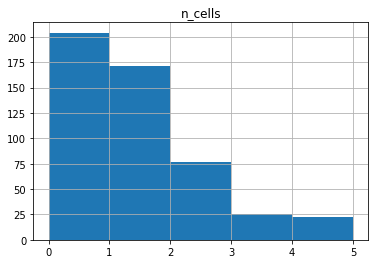

In [24]:
counts = pd.DataFrame(n_cells)
counts.hist('n_cells', bins=np.arange(6))

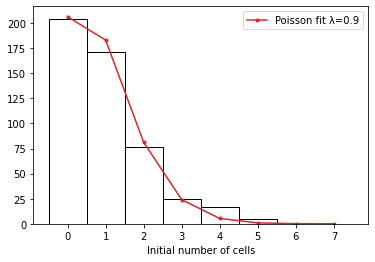

0.8873107127678457

In [25]:
poisson.fit(counts.n_cells)

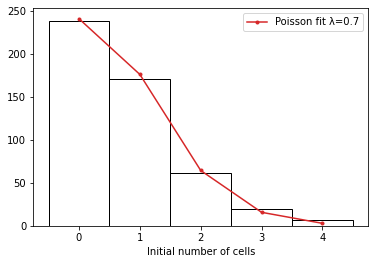

0.7309209807204495

In [26]:
poisson.fit(counts_25.n_cells)

## Try to align a mask with the BF from timelapse

In [ ]:
aligned_mask = register.align_mask_to_bf('/home/aaristov/Multicell/Lena/Data/20210518_control/chip_OD_6e-4_CFBF_CFTRITC_WFTRITC_30min_48h_bin4-bf-frame0.tif', template16=template16, mask2=good_mask1, binnings=(4,16,1), plot=True)

In [11]:
timelapse_bf = tf.imread('/pasteur/sonic/homes/aaristov/Anchor//Lena/Data/20210518_control/chip_OD_6e-4_CFBF_CFTRITC_WFTRITC_30min_48h_bin4-bf-frame0.tif')
timelapse_fluo = tf.imread('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210518_control/chip_OD_6e-4_CFBF_CFTRITC_WFTRITC_30min_48h_bin4-WFTRITC-all.tif')
mask = good_mask1
timelapse_fluo.shape

(97, 3511, 11125)

In [ ]:
out = register.align_timelapse(timelapse_bf, timelapse_fluo[:], template16, mask, plot=True, binnings=(4,16,1))

In [20]:
aligned_fluo_timelapse = np.array(out[1], dtype='uint16')
aligned_mask = out[2]
aligned_bf = out[0]

In [15]:
tf.imwrite('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210518_control/chip_OD_6e-4_CFBF_CFTRITC_WFTRITC_30min_48h_bin4-WFTRITC-all_aligned.tif', np.array(out[1], dtype='uint16'))

## Get intensities

In [ ]:
big_labels_bin2 = tf.imread('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/labels_bin2+100.tif')

In [8]:
aligned_fluo_timelapse = tf.imread('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210518_control/chip_OD_6e-4_CFBF_CFTRITC_WFTRITC_30min_48h_bin4-WFTRITC-all_aligned.tif')

In [9]:
aligned_fluo_timelapse.shape

(97, 3272, 10448)

In [78]:
big_labels_bin4 = big_labels_bin2[::2, ::2]
big_labels_bin4.shape

(3272, 10448)

In [10]:
df = mw.get_intensity_table(big_labels_bin4, aligned_fluo_timelapse[:], plot=False)

In [40]:
df.loc[:,'h'] = df.time * .5

df

time label  mean_intensity     bg_mean         I     h
time                                                       
0.0     0     1      140.303017  140.624172 -0.321155   0.0
0.0     0     2      133.718724  134.219745 -0.501021   0.0
0.0     0     3      141.614537  141.572337  0.042200   0.0
0.0     0     4      139.102398  141.261206 -2.158808   0.0
0.0     0     5      156.112989  156.518639 -0.405650   0.0
...   ...   ...             ...         ...       ...   ...
48.0   96   497      131.596372  128.371622  3.224751  48.0
48.0   96   498      137.420322  131.516667  5.903656  48.0
48.0   96   499      137.522331  133.985294  3.537037  48.0
48.0   96   500      137.401810  134.950413  2.451397  48.0
48.0   96   501      139.333731  135.207420  4.126312  48.0

[48597 rows x 6 columns]

In [14]:
df.to_csv('~/Anchor/Lena/Data/20210518_control/intensities.csv', )

In [3]:
df = pd.read_csv('~/Anchor/Lena/Data/20210518_control/intensities.csv', index_col=0)

In [3]:
df

time  label  mean_intensity     bg_mean         I     h
0       0      1      140.303017  140.624172 -0.321155   0.0
1       0      2      133.718724  134.219745 -0.501021   0.0
2       0      3      141.614537  141.572337  0.042200   0.0
3       0      4      139.102398  141.261206 -2.158808   0.0
4       0      5      156.112989  156.518639 -0.405650   0.0
..    ...    ...             ...         ...       ...   ...
496    96    497      131.596372  128.371622  3.224751  48.0
497    96    498      137.420322  131.516667  5.903656  48.0
498    96    499      137.522331  133.985294  3.537037  48.0
499    96    500      137.401810  134.950413  2.451397  48.0
500    96    501      139.333731  135.207420  4.126312  48.0

[48597 rows x 6 columns]

In [2]:
pd.read_excel('/home/aaristov/Multicell/Lena/Data/Analysis MIC/mic_count_all.xlsx')

PermissionError: [Errno 13] Permission denied

(-50.0, 150.0)

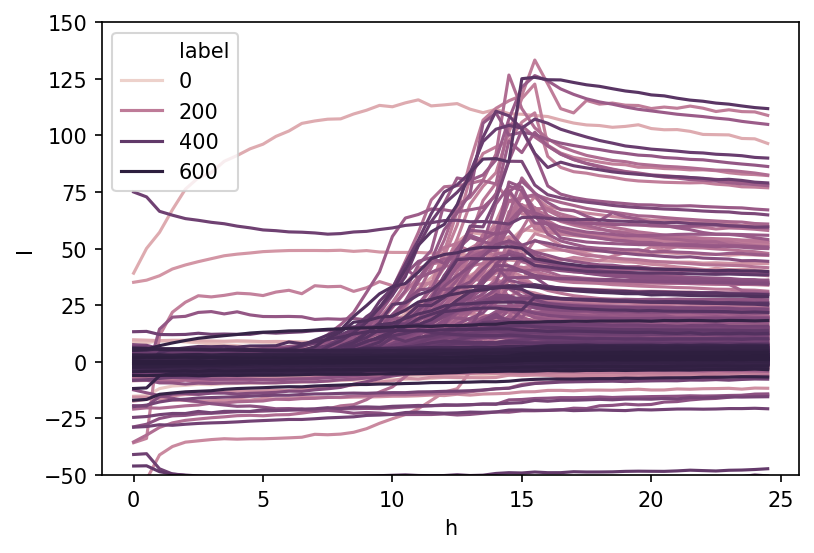

In [4]:
plt.subplots(dpi=150)
mw.sns.lineplot(x='h', y='I', data=df.query('time < 50'), estimator=None, units='label', hue='label')
plt.ylim(-50,150)

In [4]:
f_df = mw.filter_table_by_max_intensity(df, 'I', 10, 10)
f_df = mw.filter_table_by_min_intensity(f_df, 'I', 0, -10)
f_df = mw.filter_table_by_min_intensity(f_df, 'I', 26, 20)

/home/aaristov/Documents/nd2shrink/droplet_growth/multiwell.py:317: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return table[table[table.time == time].loc[:, column] < max_intensity]
/home/aaristov/Documents/nd2shrink/droplet_growth/multiwell.py:307: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return table[table[table.time == time].loc[:, column] > min_intensity]
/home/aaristov/Documents/nd2shrink/droplet_growth/multiwell.py:307: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return table[table[table.time == time].loc[:, column] > min_intensity]


In [6]:
plate_data = pd.read_csv("/home/aaristov/Multicell/Lena/Data/20210518_96wells_GrowthCurve/data.csv", index_col=0)
plate_data.loc[:,'hours'] = plate_data['h.1']
plate_data

Reading  avg. time [s]         coord       RFP  label row  column  \
h                                                                              
0.000000         1           0.00  Blank1 (A01) -0.006357  Blank   A       1   
0.166864         2         600.71  Blank1 (A01) -0.007141  Blank   A       1   
0.333794         3        1201.66  Blank1 (A01) -0.001082  Blank   A       1   
0.500681         4        1802.45  Blank1 (A01)  0.001959  Blank   A       1   
0.667606         5        2403.38  Blank1 (A01) -0.002730  Blank   A       1   
...            ...            ...           ...       ...    ...  ..     ...   
47.402842      285      170650.23  Blank1 (H12)  0.003108  Blank   H      12   
47.569772      286      171251.18  Blank1 (H12) -0.000473  Blank   H      12   
47.736669      287      171852.01  Blank1 (H12)  0.002570  Blank   H      12   
47.903606      288      172452.98  Blank1 (H12) -0.003280  Blank   H      12   
48.070506      289      173053.82  Blank1 (H12)  0.004471  Blank   H      12   

           ng        h.1      hours  
h                                    
0.000000   -1   0.000000   0.000000  
0.166864   -1   0.166864   0.166864  
0.333794   -1   0.333794   0.333794  
0.500681   -1   0.500681   0.500681  
0.667606   -1   0.667606   0.667606  
...        ..        ...        ...  
47.402842  -1  47.402842  47.402842  
47.569772  -1  47.569772  47.569772  
47.736669  -1  47.736669  47.736669  
47.903606  -1  47.903606  47.903606  
48.070506  -1  48.070506  48.070506  

[27744 rows x 10 columns]

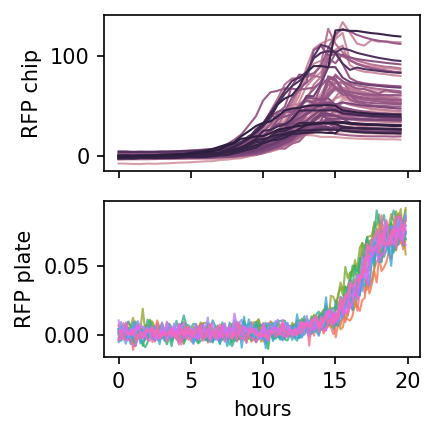

In [7]:
fig, ax = plt.subplots(nrows=2, dpi=150, figsize=(3,3), sharex=True,)
# plt.ylim(-50,150)
g = mw.sns.lineplot(ax=ax[1], data=plate_data.query('ng == 0 and hours<20'), x='hours', y='RFP', estimator=None, units='coord', hue='coord', lw=1, alpha=.8)
g.legend_.remove()
f = mw.sns.lineplot(ax=ax[0], x='h', y='I', data=f_df.query('h<20'), estimator=None, units='label', hue='label', lw=1)
f.legend_.remove()
ax[0].set_ylabel('RFP chip')
ax[1].set_ylabel('RFP plate')
# ax[1].set_ylim(-.02,.12)
# ax[0].set_ylim(-50,150)
# ax[0].set_title('Growth curves plate vs. chip')
plt.tight_layout()
fig.savefig('/home/aaristov/Multicell/Andrey/ELIFE_DRAFT/Figure1/growth_curves.pdf')

(-50.0, 150.0)

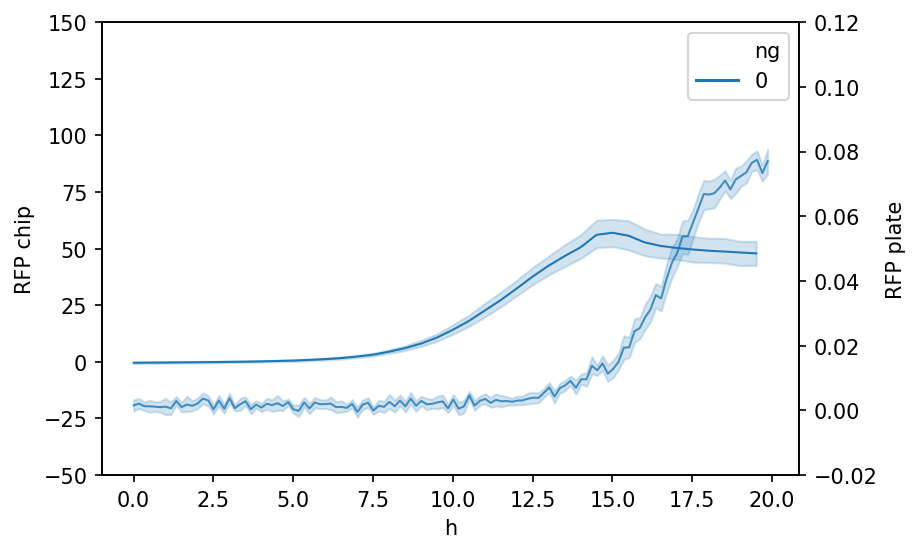

In [8]:
fig, ax = plt.subplots(dpi=150)
ax2 = ax.twinx()
# plt.ylim(-50,150)
g = mw.sns.lineplot(ax=ax2, data=plate_data.query('ng == 0 and hours<20'), x='hours', y='RFP', lw=1, alpha=.8, hue='ng')
# g.legend_.remove()
f = mw.sns.lineplot(ax=ax, x='h', y='I', data=f_df.query('h<20'), lw=1, palette="Set2")
# f.legend_.remove()
ax.set_ylabel('RFP chip')
ax2.set_ylabel('RFP plate')
ax2.set_ylim(-.02,.12)
ax.set_ylim(-50,150)

In [12]:
f_df.index = f_df.h
f_df

time  label  mean_intensity     bg_mean          I     h
h                                                             
0.0      0     87      134.657481  135.521667  -0.864185   0.0
0.0      0     88      129.206134  129.158983   0.047152   0.0
0.0      0     89      137.419427  135.079580   2.339848   0.0
0.0      0     92      131.504140  131.783113  -0.278972   0.0
0.0      0    103      139.116980  141.826377  -2.709398   0.0
...    ...    ...             ...         ...        ...   ...
48.0    96    416      155.198611  130.501650  24.696961  48.0
48.0    96    420      142.620768  123.590136  19.030632  48.0
48.0    96    421      151.045227  130.691152  20.354075  48.0
48.0    96    428      169.846879  134.207120  35.639759  48.0
48.0    96    433      155.618257  131.055105  24.563152  48.0

[7275 rows x 6 columns]

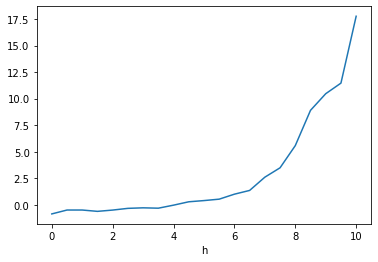

In [13]:
curve = f_df.query('label == 87')
curve.I[:10].plot()

No fit
No fit
No fit
No fit
No fit


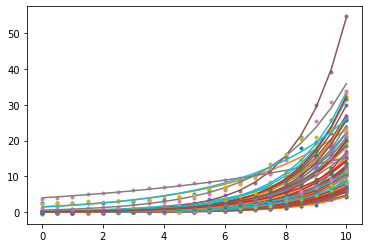

In [27]:
# c = curve.I[:10]
fits = [fit.fit_exp_on_baseline((c := f_df.query(f'label == {i}').loc[:10]).I, x=c.index, plot='linear', markers=['.', '-'], legend=False )
        for i in f_df.label.unique()]

plt.show()

No fit
No fit
No fit
No fit
No fit


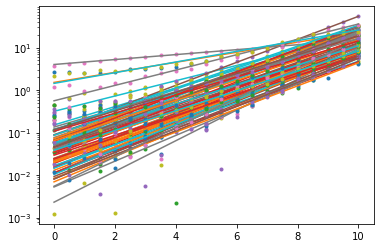

In [92]:
# c = curve.I[:10]
fits = [fit.fit_exp_on_baseline((c := f_df.query(f'label == {i}').loc[:10]).I, x=c.index, plot='log', markers=['.', '-'], legend=False )
        for i in f_df.label.unique()]

plt.show()

In [29]:
fits

[array([-0.82494468,  0.08597363,  0.53539192]),
 array([-0.06556196,  0.05334034,  0.5452029 ]),
 array([1.90124387, 0.04488162, 0.54686734]),
 array([-0.15777346,  0.0398428 ,  0.55813266]),
 array([-2.41899778,  0.15063254,  0.49905826]),
 array([-4.34456605,  1.51398257,  0.27250777]),
 array([0.62768037, 0.01124731, 0.69109384]),
 array([1.84572708, 0.01080707, 0.65306447]),
 array([-0.78416032,  0.01111501,  0.68023055]),
 array([1.07260511, 0.31614685, 0.4144608 ]),
 (None, None, None),
 array([-0.47260728,  0.06451629,  0.57235491]),
 array([-0.85259293,  0.0148815 ,  0.65761986]),
 array([-0.67397508,  0.00803036,  0.72586815]),
 (None, None, None),
 array([-2.27903541,  0.12094799,  0.39029516]),
 array([0.78491002, 0.02162562, 0.62618716]),
 array([-0.53662516,  0.00692264,  0.68544868]),
 array([0.84963564, 0.01580623, 0.66946466]),
 array([-1.02531077,  0.03229431,  0.60019895]),
 (None, None, None),
 array([0.37007864, 0.02470473, 0.61415146]),
 array([-1.0186276 ,  0.016

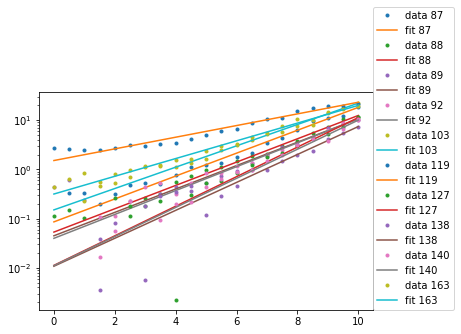

In [26]:
# c = curve.I[:10]
_ = [fit.fit_exp_on_baseline((c := f_df.query(f'label == {i}').loc[:10]).I, x=c.index, plot='log', markers=['.', '-'], legend=True, labels=[f'data {i}', f'fit {i}'] )
        for i in f_df.label.unique()[:10]]

plt.show()

No fit
No fit


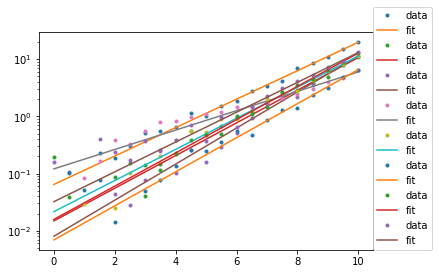

In [28]:
# c = curve.I[:10]
_ = [fit.fit_exp_on_baseline((c := f_df.query(f'label == {i}').loc[:10]).I, x=c.index, plot='log', markers=['.', '-'], legend=True )
        for i in f_df.label.unique()[10:20]]

plt.show()

Text(0.5, 1.0, 'mean rate 0.58 per h, doubling time 1.2h')

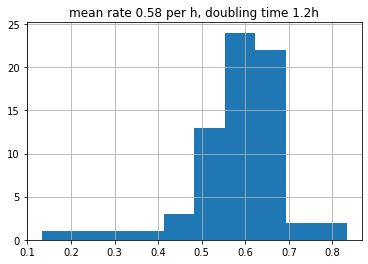

In [31]:
fits_df = pd.DataFrame(data=fits, columns=['a','b','c'])
fits_df.loc[:,'label'] = f_df.label.unique()
fits_df.c.hist(label='18 may')
rate = fits_df.c.mean()
dt = np.log(2) / rate
plt.title(f'mean rate {rate:.2f} per h, doubling time {dt:.1f}h')

In [68]:
fits_df

a         b         c  label
0  -0.824945  0.085974  0.535392     87
1  -0.065562  0.053340  0.545203     88
2   1.901244  0.044882  0.546867     89
3  -0.157773  0.039843  0.558133     92
4  -2.418998  0.150633  0.499058    103
..       ...       ...       ...    ...
70 -2.131731  0.064964  0.543638    416
71 -0.539149  0.107479  0.489568    420
72  0.025707  0.116490  0.507603    421
73 -0.572618  0.560016  0.415957    428
74 -2.919886  1.438016  0.289288    433

[75 rows x 4 columns]

In [69]:
fits_df.to_csv('/home/aaristov/Multicell/Lena/Data/20210518_control/growth_fits.csv')

In [67]:
f_df.h.name = 'hours'
f_df

time  label  mean_intensity     bg_mean          I     h
h                                                             
0.0      0     87      134.657481  135.521667  -0.864185   0.0
0.0      0     88      129.206134  129.158983   0.047152   0.0
0.0      0     89      137.419427  135.079580   2.339848   0.0
0.0      0     92      131.504140  131.783113  -0.278972   0.0
0.0      0    103      139.116980  141.826377  -2.709398   0.0
...    ...    ...             ...         ...        ...   ...
48.0    96    416      155.198611  130.501650  24.696961  48.0
48.0    96    420      142.620768  123.590136  19.030632  48.0
48.0    96    421      151.045227  130.691152  20.354075  48.0
48.0    96    428      169.846879  134.207120  35.639759  48.0
48.0    96    433      155.618257  131.055105  24.563152  48.0

[7275 rows x 6 columns]

In [70]:
f_df.to_csv('/home/aaristov/Multicell/Lena/Data/20210518_control/growth_curves.csv')

In [71]:
df.to_csv('/home/aaristov/Multicell/Lena/Data/20210518_control/all_curves.csv')

In [39]:
f_df.label.unique()

array([87, 88, 89, 92, 103, 119, 127, 138, 140, 163, 166, 167, 169, 173,
       174, 176, 185, 187, 188, 191, 192, 194, 198, 199, 207, 213, 215,
       218, 220, 223, 225, 226, 234, 250, 254, 255, 260, 261, 266, 267,
       273, 281, 283, 284, 285, 286, 288, 290, 294, 295, 299, 301, 303,
       308, 309, 318, 321, 323, 324, 326, 328, 333, 343, 346, 350, 381,
       382, 402, 414, 415, 416, 420, 421, 428, 433], dtype=object)

In [38]:
len(f_df.label.unique())

75

In [3]:
f_df = pd.read_csv('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210518_control/intensities_filtered.csv', index_col=0)

In [3]:
f_df = pd.read_csv('~/Anchor/Lena/Data/20210518_control/intensities_filtered.csv', index_col=0)

(120.0, 500.0)

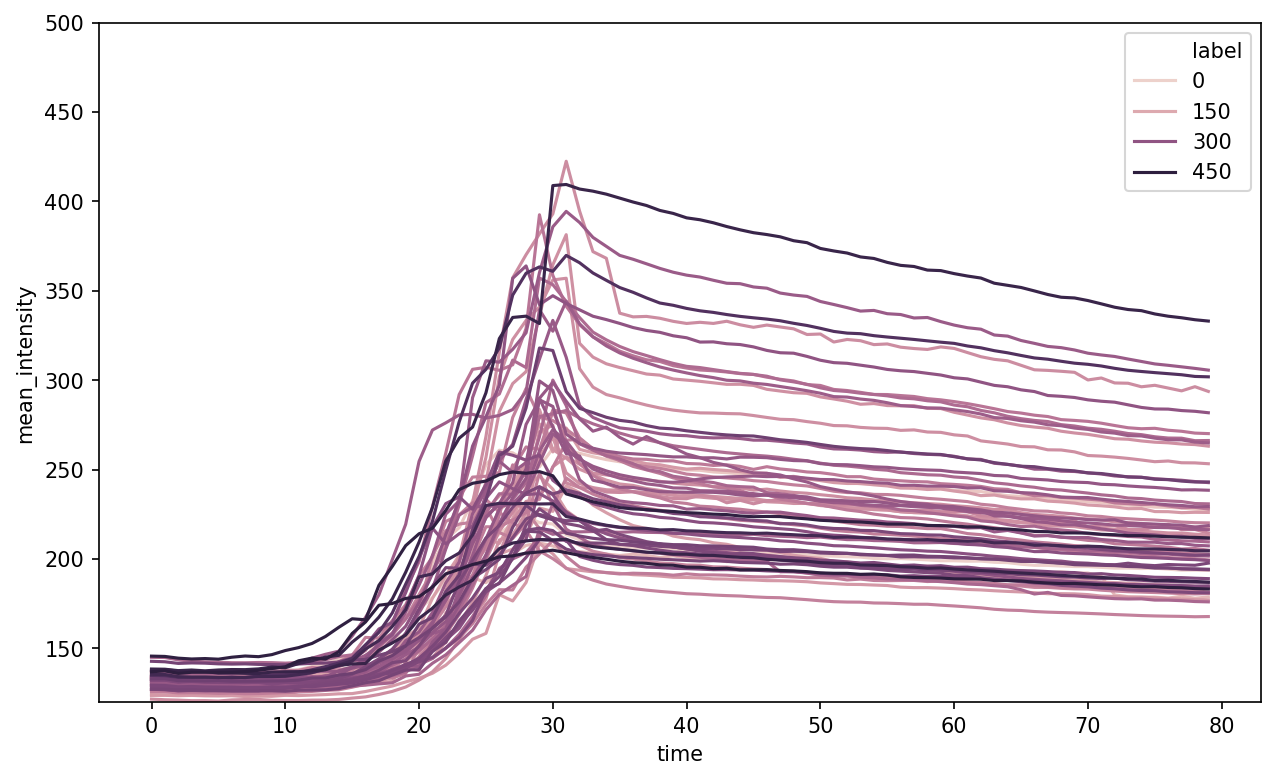

In [120]:
fig, ax = plt.subplots(dpi=150, figsize=(10, 6))
mw.sns.lineplot(ax=ax, x='time', y='mean_intensity', data=f_df.query('time < 80'), estimator=None, units='label', hue='label')
ax.set_ylim(120,500)
# ax.

In [79]:
f_df

time  label  mean_intensity     bg_mean          I     h
h                                                             
0.0      0     87      134.657481  135.521667  -0.864185   0.0
0.0      0     88      129.206134  129.158983   0.047152   0.0
0.0      0     89      137.419427  135.079580   2.339848   0.0
0.0      0     92      131.504140  131.783113  -0.278972   0.0
0.0      0    103      139.116980  141.826377  -2.709398   0.0
...    ...    ...             ...         ...        ...   ...
48.0    96    416      155.198611  130.501650  24.696961  48.0
48.0    96    420      142.620768  123.590136  19.030632  48.0
48.0    96    421      151.045227  130.691152  20.354075  48.0
48.0    96    428      169.846879  134.207120  35.639759  48.0
48.0    96    433      155.618257  131.055105  24.563152  48.0

[7275 rows x 6 columns]

In [80]:
f_df.to_csv('/pasteur/sonic/homes/aaristov/Anchor/Lena/Data/20210518_control/intensities_filtered.csv', )

In [81]:
table = f_df


ids = table.label.unique()
ids

array([ 87,  88,  89,  92, 103, 119, 127, 138, 140, 163, 166, 167, 169,
       173, 174, 176, 185, 187, 188, 191, 192, 194, 198, 199, 207, 213,
       215, 218, 220, 223, 225, 226, 234, 250, 254, 255, 260, 261, 266,
       267, 273, 281, 283, 284, 285, 286, 288, 290, 294, 295, 299, 301,
       303, 308, 309, 318, 321, 323, 324, 326, 328, 333, 343, 346, 350,
       381, 382, 402, 414, 415, 416, 420, 421, 428, 433])

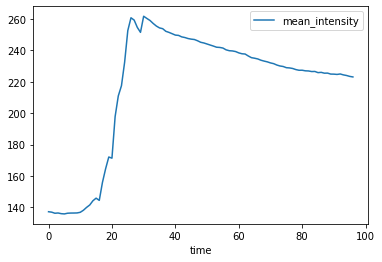

In [91]:
table[table.label == ids[1]].plot(x='time', y='mean_intensity')

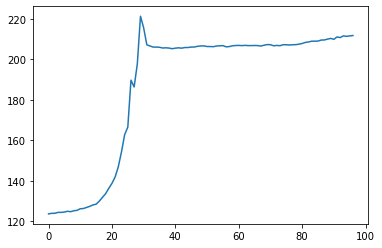

In [119]:
plt.plot(table[table.label == ids[6]].mean_intensity.values / np.exp(-2e-3 * np.arange(97)))

In [22]:
def get_peak_time(curve:np.array):
    grad = np.gradient(curve)
    return np.argmax(grad[:np.argmin(grad)])

def get_curve(table, i):
    return table[table.label == i].mean_intensity.values

def get_exp_phase(curve):
    return curve[:get_peak_time(curve)]

def get_decay_phase(curve):
    return curve[np.argmax(curve):]

In [43]:
curve = get_exp_phase(get_curve(table, ids[1]))

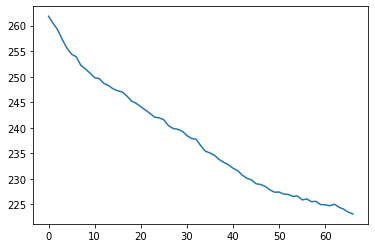

In [70]:
decay = get_decay_phase(get_curve(table, ids[1]))
plt.plot(decay)

/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/aaristov/Documents/nd2shrink/droplet_growth/fit.py:131: RuntimeWarning: overflow encountered in exp
  return a + b * np.exp(c * x)
/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/aaristov/Documents/nd2shrink/droplet_growth/fit.py:131: RuntimeWarning: overflow encountered in exp
  return a + b * np.exp(c * x)
/home/aaristov/Documents/nd2shrink/droplet_growth/fit.py:131: RuntimeWarning: overflow encountered in exp
  return a + b * np.exp(c * x)


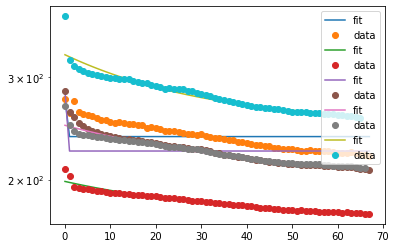

In [100]:
decays = [fit.fit_exponent((curve := get_decay_phase(get_curve(table, i))), 
                         bins=np.arange(0, len(curve)/2, .5), 
                         fun=fit.exp_on_baseline, 
                         p0=(100., -.5, -.5), bounds=(-np.inf, np.inf),
                 plot='log', plot_init=False)[:] for i in ids[5:10]]
plt.show()

/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/s

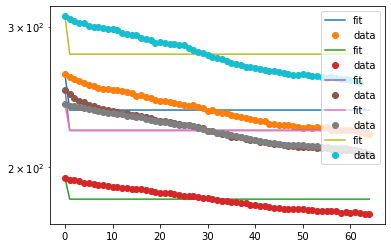

In [99]:
decays = [fit.fit_exponent((curve := get_decay_phase(get_curve(table, i))[3:]), 
                         bins= None, 
                         fun=fit.exp_on_baseline, 
                         p0=(100., -.5, -.5), bounds=(-np.inf, np.inf),
                 plot='log', plot_init=False)[:] for i in ids[5:10]]
plt.show()

In [101]:
decays

[array([237.11826134,  38.44631801, -64.77073565]),
 array([ 1.71250039e+02,  2.73698414e+01, -5.80168001e-02]),
 array([223.97450482,  59.65686635, -44.62858205]),
 array([ 2.01345023e+02,  4.65876676e+01, -5.15784689e-02]),
 array([ 2.49991846e+02,  7.76039719e+01, -7.12788851e-02])]

array([9.38343095e+01, 3.40273870e+01, 7.90689186e-02])

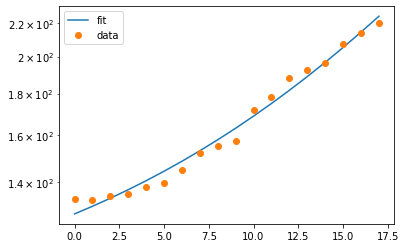

In [107]:
fit.fit_exp_on_baseline(get_exp_phase(get_curve(table, ids[0]))[10:], plot="log")

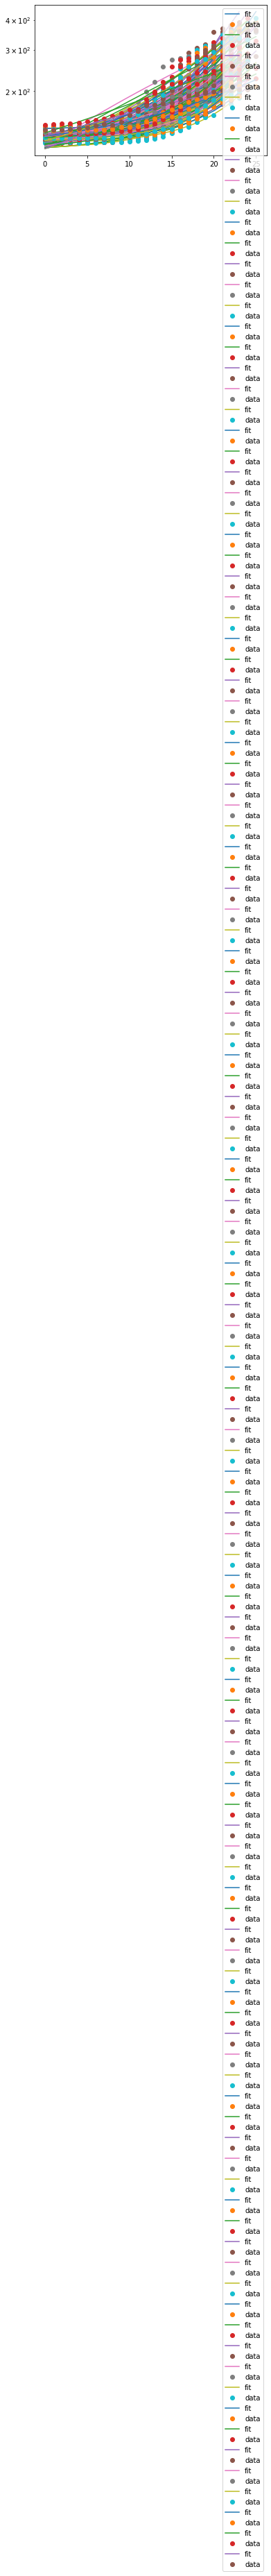

In [116]:
fits = [fit.fit_exponent((curve := get_exp_phase(get_curve(table, i))[5:]), bins=np.arange(0, len(curve)/2, .5), fun=fit.exp_on_baseline, p0=(100., .5,.5), bounds=(-np.inf, np.inf),
                 plot='log', plot_init=False)[2] for i in ids]
plt.show()

(array([1., 0., 2., 1., 1., 1., 3., 2., 1., 3., 3., 4., 3., 4., 8., 4., 6.,
        7., 0., 1.]),
 array([0.01813935, 0.04041926, 0.06269917, 0.08497908, 0.10725899,
        0.1295389 , 0.15181881, 0.17409872, 0.19637863, 0.21865854,
        0.24093845, 0.26321836, 0.28549827, 0.30777818, 0.33005809,
        0.352338  , 0.37461791, 0.39689782, 0.41917773, 0.44145763,
        0.46373754]),
 <a list of 20 Patch objects>)

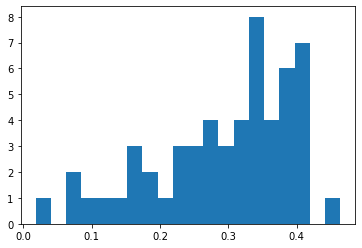

In [117]:
plt.hist(fits, bins=20)